<figure>
<center><img align='center' src='https://github.com/BellyTheMagnificent/FeedforwardNeuralNetwork_Keras/blob/master/content/NYPlogo.jpg?raw=true' />
</center></figure>





# **CIFAR-10 images classification by Feedforward Neural Network**

-----------------
## Authors
* LEE CHUN WAI
* NG CHONG SOON


## Objectives



*   Design fully connected neural network on tensorflow 2.0 and Keras
*   Experiment on using regularization to improve model performance 
*   Explore how width and depth of the neural network can impact to model's performance




# Introduction

In image classification task, we have seen neural networks performing exceptionally on MNIST dataset. Therefore in this notebook, we would like to explore what type of performances we would get if classifying colored images.

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 80 million color images (32x32). This dataset is used for image recognition and is collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

We will perform classification on a subset of the CIFAR-10 dataset (60000 images). The dataset is divided into train and test set. There are 10 classes in this dataset.

Tensorflow Keras will be used throughout this notebook as part of this learning journey.

# Loading, understanding, and processing data

## Import libraries

Import the required libaries as follows

*   numpy - for some matrix math outside of TensorFlow
*   os - read files and directory structure
*   matplotlib - plot graph in python
*   pickle - read data from cifar10 datasets
*   Scipy, PIL - Process input image for prediction
*   sklearn - Rescale input data



In [1]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import numpy as np
import os, datetime, math, random, collections, h5py
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
from scipy import ndimage
from tensorflow.keras.layers import Dropout, Dense, Flatten, Activation, LeakyReLU, PReLU, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, optimizers, regularizers, backend, initializers, callbacks
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
import pickle

Initialize random seed to make random function call consistent and result is reproducible

In [0]:
np.random.seed(123)
tf.compat.v1.random.set_random_seed(123)



## Getting Data
First let's download CIFAR10 dataset from Universeity of Toronto

In [4]:
_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

zip_dir = tf.keras.utils.get_file('cifar10.zip', origin=_URL, extract=True, cache_dir='/content/')

170500096/170498071 [==============================] - 4s 0us/step


The downloaded zip files contain 5 training datasets, 1 test datasets, and a meta file describe data

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>datasets</b>
|__ <b>cifar-10-batches-py</b>
    |______ <b>batches.meta</b>
    |______ <b>data_batch_1</b>
    |______ <b>data_batch_2</b>
    |______ <b>data_batch_3</b>
    |______ <b>data_batch_4</b>
    |______ <b>data_batch_5</b>
    |______ <b>readme.html</b>
    |______ <b>test_batch</b>
</pre>

As described by [Alex Krizhevsky](https://en.wikipedia.org/wiki/AlexNet), each of these files is a Python "pickled" object produced with cPickle. We can use the provided function below to load the data into python dictionary object

In [0]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

## Understanding data
Let's take a look at the content of the 1st data batch using function above

In [6]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cifar-10-batches-py')
data_1 = unpickle(os.path.join(base_dir,'data_batch_1'))

print('Content of  data file: ', list(data_1))
print('Length of input data: ', len(data_1['data'][0]))
print('Sample data: ', (data_1['data'][0]))
print('Length of output data: ', len(data_1['labels'][0:1]))


meta = unpickle(os.path.join(base_dir,'batches.meta'))
print('Content of meta: ', meta)

Content of  data file:  ['batch_label', 'labels', 'data', 'filenames']
Length of input data:  3072
Sample data:  [ 59  43  50 ... 140  84  72]
Length of output data:  1
Content of meta:  {'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


## Processing Data

Now we will create a function to concatenate 6 batches of data into train data, train label, test data, and test label.

In [0]:
def load_datasets(path):
  train_x = []
  train_y = []
  test_x = []
  test_y = []
  classes = []
  for file in os.listdir(base_dir):
    if file.startswith('data_batch'):
      data = unpickle(os.path.join(base_dir,file))
      train_x.extend(data['data'])
      train_y.extend(data['labels'])
    if file == 'test_batch' :
      data = unpickle(os.path.join(base_dir,file))
      test_x = data['data']
      test_y = data['labels']
    if file == 'batches.meta':
      data = unpickle(os.path.join(base_dir,file))
      classes.extend(data['label_names'])
  
  train_x = np.array(train_x)
  train_y = np.array(train_y)
  test_x = np.array(test_x)
  test_y = np.array(test_y)

  return train_x, train_y, test_x, test_y, classes

In [8]:
train_x, train_y, test_x, test_y, classes = load_datasets(base_dir)

print(train_x.shape)
print(test_x.shape)
print(classes)

(50000, 3072)
(10000, 3072)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
a=dict(zip(*np.unique(train_y, return_counts=True)))
print("Training Data Distribution")
for k in a:
  print(classes[k], '\t:', a[k])


Training Data Distribution
airplane 	: 5000
automobile 	: 5000
bird 	: 5000
cat 	: 5000
deer 	: 5000
dog 	: 5000
frog 	: 5000
horse 	: 5000
ship 	: 5000
truck 	: 5000


In [10]:
a=dict(zip(*np.unique(test_y, return_counts=True)))
print("Testing Data Distribution")
for k in a:
  print(classes[k], '\t:', a[k])

Testing Data Distribution
airplane 	: 1000
automobile 	: 1000
bird 	: 1000
cat 	: 1000
deer 	: 1000
dog 	: 1000
frog 	: 1000
horse 	: 1000
ship 	: 1000
truck 	: 1000


CIFAR10 contains object classification from 32 x 32 color image. It would be better to display image and corrsponding label. However, the image information have flatten into 3072 array. To display the data as image, we will have to reverse the flatten into 32 x 32 x3 array. 

Now define 2 utility functions for purpose above:


*   ```reverse_flat``` : to reverse the flatten 3072 features back to 32 x 32 RGB information
*   ```display_image```: display image using the input of 32 x 32 RGB image information





In [0]:
def reverse_flat(datasets):
  img_data = []
  for data in (datasets):
#    r = datasets[i][0:1024].reshape(32,32)
#    g = datasets[i][1024:2048].reshape(32,32)
#    b = datasets[i][2048:].reshape(32,32)
    r = data[0:1024].reshape(32,32)
    g = data[1024:2048].reshape(32,32)
    b = data[2048:].reshape(32,32)
    img_data.append(np.dstack([r,g,b]))
  img_data = np.array(img_data)
  return img_data

def display_image(images, labels, preds=[]):

  m = images.shape[0]
  col = 8
  row = math.ceil(m / col) 
  if len(preds) == 0:
    preds = np.zeros(m)-1
  fig, axes = plt.subplots(row, col,squeeze=True, figsize=(12 ,12))
  fig.subplots_adjust(wspace=1, hspace=1)
  axes = axes.flatten()
  for img, ax, label, pred in zip(images, axes, labels, preds):
    ax.imshow(img)
    ax.set_title(classes[label])
    if pred > -1:
      if label == pred:
        ax.set_xlabel(classes[pred],color='green')
      else:
        ax.set_xlabel(classes[pred],color='red')
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
  
  while m <  (col * row):
    fig.delaxes(axes[m])
    m=m+1
  plt.tight_layout()
  plt.show()
  

Take some images from the 50000 random samples

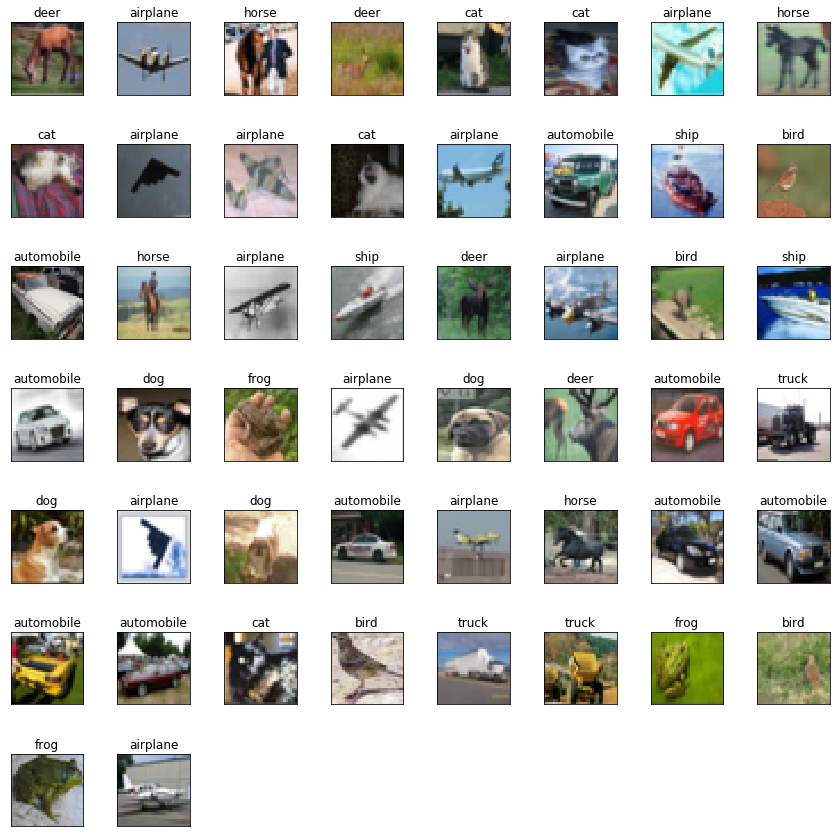

In [12]:
samples = [random.randrange(1, 50000, 1) for _ in range(50)]
display_image(reverse_flat(train_x[samples]), train_y[samples])
#display_image(reverse_flat(train_x[0:15]), train_y[0:15])
#display_image(reverse_flat(train_x[0:1]), train_y[0:1])

## Rescaling Data

To treat all pixels which train under same weights, learning rate for contributes more evenly to the loss, input data have to rescale pixel value from  [0,255] -> [0,1]


In [0]:
scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x.astype(np.float64))
test_x_scaled = scaler.fit_transform(test_x.astype(np.float64))

# Modeling 




## Consideration for Parameter



### Number of layers and neuron units

To get started without random guessing on numbers of layers and neurons for the network, the models are design based on the rules of thumb suggested by [Jeff Heaton](https://www.heatonresearch.com/2017/06/01/hidden-layers.html) as below.



#### <u>Layers</u>
<table alight='left'>
<tr> 
<td><b>Num Hidden Layers</b></td><td><b>Result</b></td>
</tr
<tr>
<td>none</td> <td>Only capable of representing linear separable functions or decisions.
</td></tr><tr><td>
1</td><td>	Can approximate any function that contains a continuous mapping from one finite space to another.
</td></tr><tr><td>
2</td><td>Can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accuracy.
</td></tr><tr><td>
>2</td><td>	Additional layers can learn complex representations (sort of automatic feature engineering) for layer layers.
</td></tr><tr>
</table>


#### <u>Neuron units</u>

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.




### Activation Functions



#### Hidden Layer

<b>ReLU</b> can avoids and rectifies vanishing gradient problem. Beside, ReLU is also less expensive in term of computation compare to other non-linear activation function. It is good option for hidden layers in most of the neural networks.

#### Output Layer


<b>Softmax</b> which allows comparison and thus supports multiple classes classification would be use for the 10 classes classifiction problem

### Initialization of weights

Zero weight initialize would make learning learning next layer become linear or same for all iteration. The best practice would be initialize weights by random values. By default, **Keras** will use ```Xavier Uniform Initalizer``` for weights. After some study [3], we found that ```Xavier Uniform Initializer``` work well for ```tanh``` activation. Since we use ```ReLU``` activation, ```HE Uniform Initalizer``` would be better option

In [0]:
init_w = initializers.he_uniform(seed=1234)

### Optimization algorithms

Stochastic Gradient Descent with Momentum

In [0]:
sgd = optimizers.SGD(learning_rate=0.01, momentum=0.7, nesterov=True, name ='SGD')

### Epoch and Batch Size

Epoch represent number of times the complete dataset is passthrough the training. Since Gradient Descent is an iterative process, updating weights with one epoch is not suffient. Large number of epoch would tend to overfitting but it help avoid local minimal. Overfitting issue can be resolve by various regularization techniques.



Batch size represent total number of training examples present in a single batch. If the batch size is 1, the training will be stochastic batch training which will update the weights for every example the model train. If the batch size is equal to total number of training examples, it would be a batch traiing which only update weights after entire dataset is scan through once. The best approach would be using mini batch which combine all the pros from two approaches above. Recommended batch size for mini batch approach would be a number that cab fit into memory. e.g. 32,64, 128, and etc. 

In [0]:
epoch = 60
batch_size = 128

### Checkpoint

Checkpoint is one of the function to safekeep the best train model over the long training process. For this assignment, we choose to save the trained model which give the highest validation accuracy as the best model. The best model will use for evaluation and prediction on test dataset. Code snippet below is use to create ```Keras ModelCheckpoint```.  

In [0]:
if not os.path.exists('/content/SavedModel/'):
  os.makedirs('/content/SavedModel/')
def get_mc(path):
  
  mc = callbacks.ModelCheckpoint(path, monitor='val_accuracy', mode='max', save_best_only=True)
  
  return mc

Before start buiding neural network model, define the function below to visualize learning loss and accuracy



In [0]:
def plot_history(history, eval_acc=None):

  print('Training accuracy: %.3f' % (history.history['accuracy'][-1] * 100))
  print('Validation accuracy: %.3f' % (history.history['val_accuracy'][-1] * 100))
  if eval_acc:
    print('Testing accuracy: %.3f' % (eval_acc * 100))
  print()
  fig, (p1, p2) = plt.subplots(1, 2, figsize=(15,5))
  # Plot training & validation accuracy values
  p1.plot(history.history['accuracy'])
  p1.plot(history.history['val_accuracy'])
  p1.set_title('Model accuracy')
  p1.set_ylabel('Accuracy')
  p1.set_xlabel('Epoch')
  p1.legend(['Train', 'Test'], loc='upper left')

  # Plot training & validation loss values
  p2.plot(history.history['loss'])
  p2.plot(history.history['val_loss'])
  p2.set_title('Model loss')
  p2.set_ylabel('Loss')
  p2.set_xlabel('Epoch')
  p2.legend(['Train', 'Test'], loc='upper right')
  plt.show()

## Model 1A - Shallow Network with small number of neurons

We start with a relative swallow and small neural networks with just 32 neurons.







### Build

In [19]:
model_1A = tf.keras.models.Sequential(name='FNN-1A', layers=[
    Dense(32, name='FNN-1A-H1', activation = 'relu', kernel_initializer=init_w,  input_shape= (3072,)),    
    #Dense(32, name='fnn1-hidden_layer1', activation = 'relu', kernel_initializer=init_w),
    Dense(10, name='FNN-1A-Output',activation = 'softmax')
])

model_1A.summary()

plot_model(model_1A)
cp_1A = '/content/SavedModel/best_1A_model.h5'
mc = callbacks.ModelCheckpoint(cp_1A,monitor='val_loss', mode='min',verbose=0, save_best_only=True)

Model: "FNN-1A"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FNN-1A-H1 (Dense)            (None, 32)                98336     
_________________________________________________________________
FNN-1A-Output (Dense)        (None, 10)                330       
Total params: 98,666
Trainable params: 98,666
Non-trainable params: 0
_________________________________________________________________


### Train





In [20]:
model_1A.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_1A = model_1A.fit(train_x_scaled, train_y,validation_split=0.2, shuffle=True,batch_size=batch_size,epochs=epoch ,verbose=1, callbacks=[mc])
model_1A_best = models.load_model(cp_1A)

Train on 40000 samples, validate on 10000 samples
Epoch 1/60
40000/40000 [==============================] - 3s 77us/sample - loss: 2.0013 - accuracy: 0.2710 - val_loss: 1.9139 - val_accuracy: 0.3191
Epoch 2/60
40000/40000 [==============================] - 2s 42us/sample - loss: 1.8222 - accuracy: 0.3544 - val_loss: 1.8434 - val_accuracy: 0.3378
Epoch 3/60
40000/40000 [==============================] - 2s 43us/sample - loss: 1.7515 - accuracy: 0.3817 - val_loss: 1.7756 - val_accuracy: 0.3755
Epoch 4/60
40000/40000 [==============================] - 2s 45us/sample - loss: 1.7061 - accuracy: 0.3964 - val_loss: 1.7792 - val_accuracy: 0.3646
Epoch 5/60
40000/40000 [==============================] - 2s 46us/sample - loss: 1.6715 - accuracy: 0.4074 - val_loss: 1.7107 - val_accuracy: 0.4042
Epoch 6/60
40000/40000 [==============================] - 2s 45us/sample - loss: 1.6434 - accuracy: 0.4197 - val_loss: 1.6858 - val_accuracy: 0.4122
Epoch 7/60
40000/40000 [==============================] 

### Evaluation

Training accuracy: 53.193
Validation accuracy: 45.180
Testing accuracy: 47.990



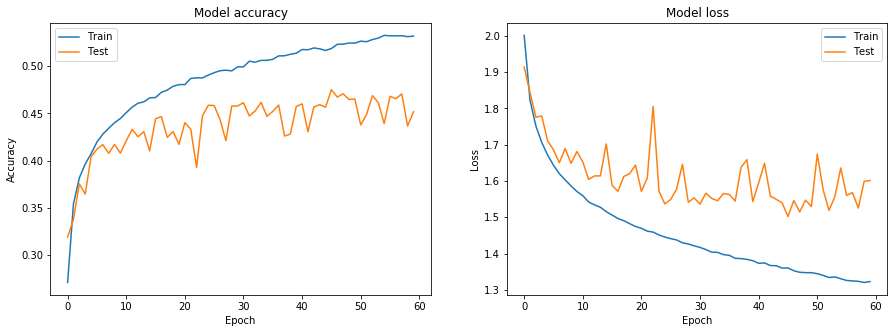

In [21]:
_,acc = model_1A_best.evaluate(test_x_scaled, test_y, verbose=0)
plot_history(history_1A, acc)

The simple shallow network offer an approximately 48% accuracy for classifying CIFAR-10 data sets. As seen above, the model start diverge after 20 epochs. 

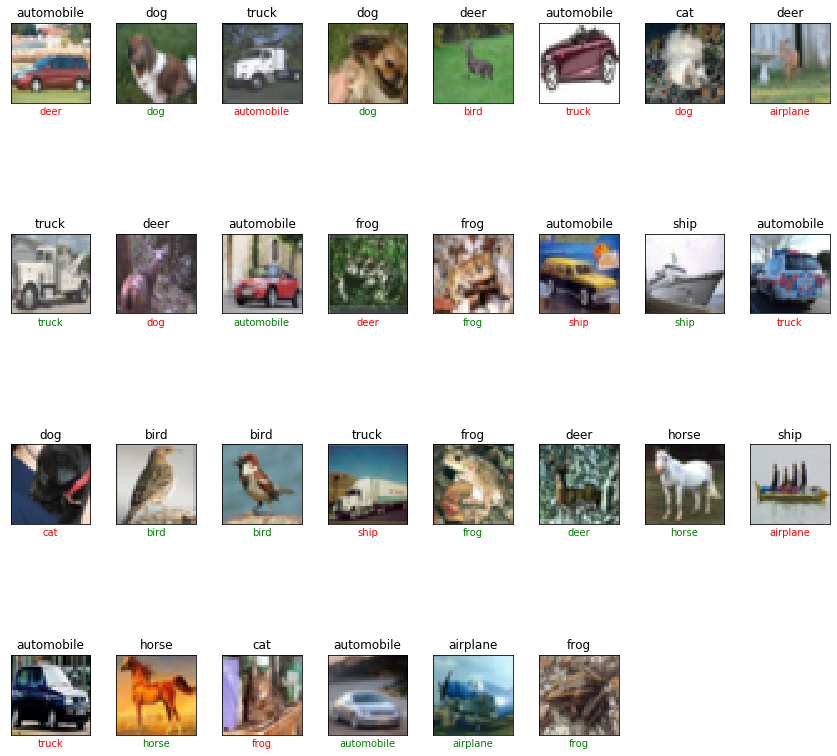

In [22]:
pred_1 = model_1A_best.predict(test_x_scaled, verbose=0)
indexes = tf.argmax(pred_1, axis=1)
pred_1_label = indexes.numpy()
samples = [random.randrange(1, 10000, 1) for _ in range(30)]
display_image(reverse_flat(test_x[samples]), test_y[samples], pred_1_label[samples])

## Model 1B - Shallow Network with larger number of neurons

Next we would check if increase number of neurons would help improve on performance.





### Build


Model: "FNN-1B"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FNN-1B-H1 (Dense)            (None, 6144)              18880512  
_________________________________________________________________
FNN-1B-Output (Dense)        (None, 10)                61450     
Total params: 18,941,962
Trainable params: 18,941,962
Non-trainable params: 0
_________________________________________________________________


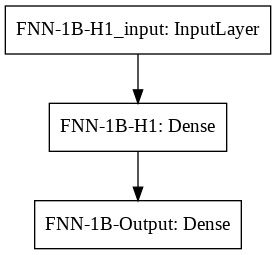

In [23]:
model_1B = tf.keras.models.Sequential(name='FNN-1B', layers=[
    #Dense(2054, name='FNN-1B-H1', activation = 'relu', kernel_initializer=init_w,  input_shape= (3072,)),    
    Dense(6144, name='FNN-1B-H1', activation = 'relu', kernel_initializer=init_w,  input_shape= (3072,)),    
    Dense(10, name='FNN-1B-Output',activation = 'softmax')
])

model_1B.summary()

cp_1B = '/content/SavedModel/best_1B_model.h5'
mc = callbacks.ModelCheckpoint(cp_1B,monitor='val_loss', mode='min',verbose=0, save_best_only=True)
plot_model(model_1B)

### Train

In [24]:
model_1B.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_1B = model_1B.fit(train_x_scaled, train_y,validation_split=0.2, shuffle=True,batch_size=batch_size,epochs=epoch ,verbose=1, callbacks=[mc])
model_1B_best = models.load_model(cp_1B)

Train on 40000 samples, validate on 10000 samples
Epoch 1/60
40000/40000 [==============================] - 5s 130us/sample - loss: 1.9040 - accuracy: 0.3621 - val_loss: 1.7713 - val_accuracy: 0.3692
Epoch 2/60
40000/40000 [==============================] - 5s 119us/sample - loss: 1.6312 - accuracy: 0.4303 - val_loss: 1.6757 - val_accuracy: 0.4020
Epoch 3/60
40000/40000 [==============================] - 5s 118us/sample - loss: 1.5546 - accuracy: 0.4594 - val_loss: 1.6023 - val_accuracy: 0.4425
Epoch 4/60
40000/40000 [==============================] - 4s 110us/sample - loss: 1.5021 - accuracy: 0.4788 - val_loss: 1.6064 - val_accuracy: 0.4224
Epoch 5/60
40000/40000 [==============================] - 5s 117us/sample - loss: 1.4565 - accuracy: 0.4949 - val_loss: 1.5653 - val_accuracy: 0.4634
Epoch 6/60
40000/40000 [==============================] - 5s 117us/sample - loss: 1.4200 - accuracy: 0.5069 - val_loss: 1.5389 - val_accuracy: 0.4631
Epoch 7/60
40000/40000 [==========================

### Evaluate

Training accuracy: 83.842
Validation accuracy: 53.190
Testing accuracy: 53.540



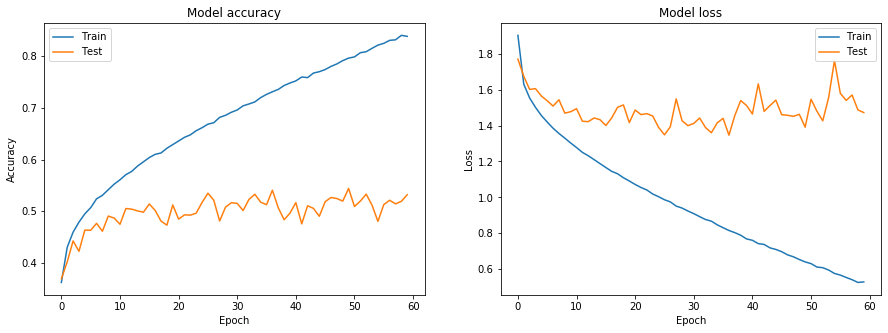

In [25]:
_,acc = model_1B_best.evaluate(test_x_scaled, test_y, verbose=0)
plot_history(history_1B, acc)

Increased too 6024 neurons gave great performance boost to training and testing accuracy. The model started with smaller loss although it reach similar number of validation loss with model 1A after 60 epochs. However, model 1B become overfitting after 10 epochs which earlier than model 1A.

Training accuracy is increase to 84% and testing accuracy increased to 53%

Hence we can conclude that increase number of neurons can improve performance, but also likely cause the model to overfitting sooner. 
We will address the overfitting issue in regularization. 

## Model 2 - 3 Layers Neural Network

Let's check if increase number of layers do help on performance.

### Build

Model: "FNN-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FNN-2-H1 (Dense)             (None, 6144)              18880512  
_________________________________________________________________
FNN-2-H2 (Dense)             (None, 3072)              18877440  
_________________________________________________________________
FNN-1A-O1 (Dense)            (None, 10)                30730     
Total params: 37,788,682
Trainable params: 37,788,682
Non-trainable params: 0
_________________________________________________________________


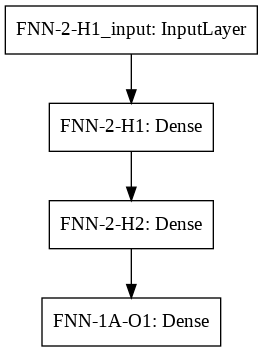

In [26]:
model_2 = tf.keras.models.Sequential(name='FNN-2', layers= [
    Dense(6144, activation = 'relu', kernel_initializer=init_w, input_shape= (3072,), name='FNN-2-H1'),    
    Dense(3072, activation = 'relu', kernel_initializer=init_w,name='FNN-2-H2'),
    Dense(10, activation = 'softmax', name='FNN-1A-O1')
])

model_2.summary()
cp_2 = '/content/SavedModel/best_2_model.h5'
mc = callbacks.ModelCheckpoint(cp_2,monitor='val_loss', mode='min',verbose=0, save_best_only=True)

plot_model(model_2)

### Train






In [27]:
model_2.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



history_2 = model_2.fit(train_x_scaled, train_y,epochs=epoch,validation_split=0.2,shuffle=True, batch_size=batch_size, verbose=1, callbacks=[mc])
model_2_best = models.load_model(cp_2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/60
40000/40000 [==============================] - 10s 240us/sample - loss: 1.8736 - accuracy: 0.3607 - val_loss: 1.7670 - val_accuracy: 0.3721
Epoch 2/60
40000/40000 [==============================] - 9s 231us/sample - loss: 1.6044 - accuracy: 0.4354 - val_loss: 1.6871 - val_accuracy: 0.4027
Epoch 3/60
40000/40000 [==============================] - 9s 232us/sample - loss: 1.5135 - accuracy: 0.4694 - val_loss: 1.5553 - val_accuracy: 0.4523
Epoch 4/60
40000/40000 [==============================] - 8s 210us/sample - loss: 1.4483 - accuracy: 0.4942 - val_loss: 1.5867 - val_accuracy: 0.4292
Epoch 5/60
40000/40000 [==============================] - 9s 232us/sample - loss: 1.3901 - accuracy: 0.5153 - val_loss: 1.4831 - val_accuracy: 0.4868
Epoch 6/60
40000/40000 [==============================] - 8s 212us/sample - loss: 1.3402 - accuracy: 0.5321 - val_loss: 1.4896 - val_accuracy: 0.4724
Epoch 7/60
40000/40000 [=========================

### Evaluation


Training accuracy: 99.480
Validation accuracy: 55.790
Testing accuracy: 54.490



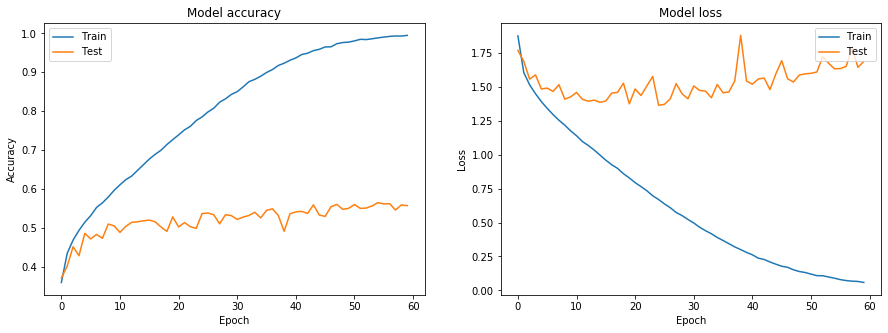

In [28]:
_,acc = model_2_best.evaluate(test_x_scaled, test_y, verbose=0)
plot_history(history_2, acc)

With the additional layer, training performance is increased to 99% and have clear signed of overfitting on train dataset. The accuracy for validation and test dataset remain hovering around 56% and 54%. The model become overfitting after 10 epochs.
The increase in validation loss show that overfitting model will reduce performance of remaining iteration.


## Model 3 Deep Neural Network

In the next cell, we will try to construct a deeper network with thinner layers. The total number of parameters would be lesser than Model 2, hence it shall delay the overfitting effect and allow the model to train longer.

### Build

Model: "FNN-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FNN-3-H1 (Dense)             (None, 2054)              6311942   
_________________________________________________________________
FNN-3-H2 (Dense)             (None, 1024)              2104320   
_________________________________________________________________
FNN-3-H3 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
FNN-3-H4 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
FNN-3-H5 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
FNN-3-H6 (Dense)             (None, 924)               947100    
_________________________________________________________________
FNN-3-H7 (Dense)             (None, 924)               854700

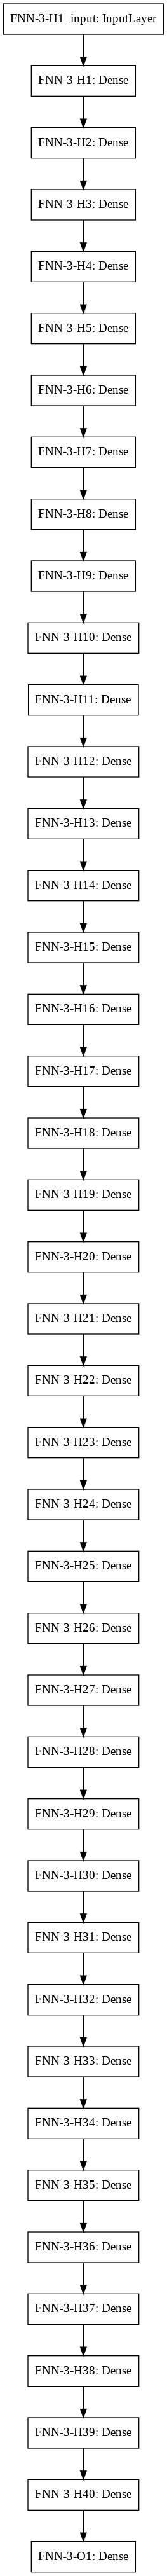

In [29]:
model_3 = tf.keras.models.Sequential(name='FNN-3', layers= [
    Dense(2054, activation='relu', kernel_initializer=init_w,  input_shape= (3072,), name='FNN-3-H1'),
    Dense(1024, activation='relu', kernel_initializer=init_w, name='FNN-3-H2'),
    Dense(1024, activation='relu', kernel_initializer=init_w, name='FNN-3-H3'),
    Dense(1024, activation='relu', kernel_initializer=init_w, name='FNN-3-H4'),
    Dense(1024, activation='relu', kernel_initializer=init_w, name='FNN-3-H5'),
    Dense(924, activation='relu', kernel_initializer=init_w, name='FNN-3-H6'),
    Dense(924, activation='relu', kernel_initializer=init_w, name='FNN-3-H7'),
    Dense(768, activation='relu', kernel_initializer=init_w, name='FNN-3-H8'),
    Dense(768, activation='relu', kernel_initializer=init_w, name='FNN-3-H9'),
    Dense(768, activation='relu', kernel_initializer=init_w, name='FNN-3-H10'),
    Dense(768, activation='relu', kernel_initializer=init_w, name='FNN-3-H11'),
    Dense(512, activation='relu', kernel_initializer=init_w, name='FNN-3-H12'),
    Dense(512, activation='relu', kernel_initializer=init_w, name='FNN-3-H13'),
    Dense(512, activation='relu', kernel_initializer=init_w, name='FNN-3-H14'),
    Dense(512, activation='relu', kernel_initializer=init_w, name='FNN-3-H15'),
    Dense(512, activation='relu', kernel_initializer=init_w, name='FNN-3-H16'),
    Dense(512, activation='relu', kernel_initializer=init_w, name='FNN-3-H17'),
    Dense(256, activation='relu', kernel_initializer=init_w, name='FNN-3-H18'),
    Dense(256, activation='relu', kernel_initializer=init_w, name='FNN-3-H19'),
    Dense(256, activation='relu', kernel_initializer=init_w, name='FNN-3-H20'),
    Dense(256, activation='relu', kernel_initializer=init_w, name='FNN-3-H21'),
    Dense(256, activation='relu', kernel_initializer=init_w, name='FNN-3-H22'),
    Dense(256, activation='relu', kernel_initializer=init_w, name='FNN-3-H23'),
    Dense(128, activation='relu', kernel_initializer=init_w, name='FNN-3-H24'),
    Dense(128, activation='relu', kernel_initializer=init_w, name='FNN-3-H25'),
    Dense(128, activation='relu', kernel_initializer=init_w, name='FNN-3-H26'),
    Dense(128, activation='relu', kernel_initializer=init_w, name='FNN-3-H27'),
    Dense(128, activation='relu', kernel_initializer=init_w, name='FNN-3-H28'),
    Dense(128, activation='relu', kernel_initializer=init_w, name='FNN-3-H29'),
    Dense(128, activation='relu', kernel_initializer=init_w, name='FNN-3-H30'),
    Dense(128, activation='relu', kernel_initializer=init_w, name='FNN-3-H31'),
    Dense(64, activation='relu', kernel_initializer=init_w, name='FNN-3-H32'),
    Dense(64, activation='relu', kernel_initializer=init_w, name='FNN-3-H33'),
    Dense(64, activation='relu', kernel_initializer=init_w, name='FNN-3-H34'),
    Dense(64, activation='relu', kernel_initializer=init_w, name='FNN-3-H35'),
    Dense(64, activation='relu', kernel_initializer=init_w, name='FNN-3-H36'),
    Dense(64, activation='relu', kernel_initializer=init_w, name='FNN-3-H37'),
    Dense(64, activation='relu', kernel_initializer=init_w, name='FNN-3-H38'),
    Dense(64, activation='relu', kernel_initializer=init_w, name='FNN-3-H39'),
    Dense(64, activation='relu', kernel_initializer=init_w, name='FNN-3-H40'),
    Dense(10, activation = 'softmax', name='FNN-3-O1')
])

model_3.summary()
cp_3 = '/content/SavedModel/best_3_model.h5'
mc = get_mc(cp_3)

plot_model(model_3)

### Train

In [30]:
model_3.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



history_3 = model_3.fit(train_x_scaled, train_y,epochs=epoch,shuffle=True,validation_split=0.2, batch_size=batch_size, verbose=1, callbacks=[mc])
model_3_best = models.load_model(cp_3)

Train on 40000 samples, validate on 10000 samples
Epoch 1/60
40000/40000 [==============================] - 11s 277us/sample - loss: 2.1872 - accuracy: 0.1478 - val_loss: 2.1475 - val_accuracy: 0.1494
Epoch 2/60
40000/40000 [==============================] - 9s 223us/sample - loss: 2.0357 - accuracy: 0.2002 - val_loss: 2.0414 - val_accuracy: 0.2045
Epoch 3/60
40000/40000 [==============================] - 9s 222us/sample - loss: 1.9676 - accuracy: 0.2391 - val_loss: 1.8645 - val_accuracy: 0.2853
Epoch 4/60
40000/40000 [==============================] - 8s 196us/sample - loss: 1.8716 - accuracy: 0.2846 - val_loss: 1.9787 - val_accuracy: 0.2787
Epoch 5/60
40000/40000 [==============================] - 8s 198us/sample - loss: 1.8082 - accuracy: 0.3165 - val_loss: 1.9861 - val_accuracy: 0.2496
Epoch 6/60
40000/40000 [==============================] - 9s 224us/sample - loss: 1.7713 - accuracy: 0.3354 - val_loss: 1.7805 - val_accuracy: 0.3425
Epoch 7/60
40000/40000 [=========================

### Evaluation

Training accuracy: 77.185
Validation accuracy: 49.410
Testing accuracy: 50.940



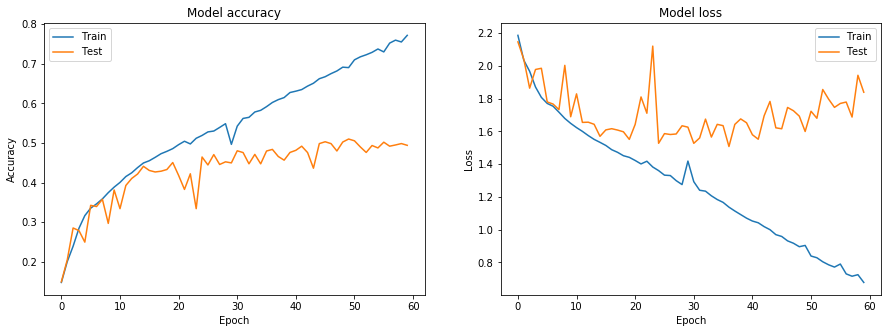

In [31]:
_,acc = model_3_best.evaluate(test_x_scaled, test_y, verbose=0)
plot_history(history_3, acc)

The training accuracy graph is smoother compare to other models. Accuracy is increase slower in each iteration. 
Although thinner network can avoid early overfitting, but there is increase in training error for the overall model. After 40 epochs, the validation loss begin to diverge from training loss, show that the model isn't able to improve further due to overfitting.

# Regularization

In the following cells, we will be performing regularization.

The objective of regularization is to reduce the effect of overfitting. Overfitting is observed when the training accuracy is much higher than validation accuracy. When training accuracy is too high, that means that the model is not robust when predicting new data, or in other words it could not generalize.

There are various regularization techniques. We will be using L1 L2 regularization and Dropout to regulate the shallow and deep models respectively.

##L1 L2 Regularization

In this cell we will set the L1 and L2 regularizer to 0.0001. This figure is much smaller than expected. These parameters were determined through trying from a range of 0.5 to 0.00001. 

When the L1 and L2 values are closer to 0.00001, the model will overfit as per no regularization.

And when the values approaches 0.5, the accuracies start oscillating.



In [0]:
l1_l2 = regularizers.l1_l2(l1=0.000085,l2=0.000085)


###Model 1 (L1 L2)
Defining and train the model with L1 and L2 regularizers.


In [33]:
model_1_reg = tf.keras.models.Sequential(name='FNN-1-Reg', layers=[
    Dense(3072, activation='relu',kernel_initializer=init_w,bias_initializer=init_w,input_shape= (3072,), kernel_regularizer=l1_l2, bias_regularizer=l1_l2), 
    Dense(1024, activation='relu',kernel_initializer=init_w,bias_initializer=init_w, kernel_regularizer=l1_l2, bias_regularizer=l1_l2),   
    Dense(10, activation = 'softmax')
])

model_1_reg.summary()
model_1_reg.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_1_reg = model_1_reg.fit(train_x_scaled, train_y,validation_split=0.2, batch_size=batch_size,shuffle=True,epochs=100 ,verbose=1)

Model: "FNN-1-Reg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3072)              9440256   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 12,597,258
Trainable params: 12,597,258
Non-trainable params: 0
_________________________________________________________________
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 7s 177us/sample - loss: 25.6928 - accuracy: 0.3468 - val_loss: 25.1350 - val_accuracy: 0.3608
Epoch 2/100
40000/40000 [==============================] - 6s 153us/sample - loss: 24.4896 - accuracy: 0.4193 - val_loss: 24.0695 - val_accuracy: 0.3884
Epoch 3/100
40000/4

### Evaluation
The following shows the accuracy and loss graphs for regulated shallow model. 

We observe that training and validation accuracies are close to each other as compared with unregularized model.

As the training goes on in more epoch, the training accuracy does not increase too much over validation accuracy. This show that we curb overfitting to an extent.


Training accuracy: 61.195
Validation accuracy: 52.620
Testing accuracy: 52.990



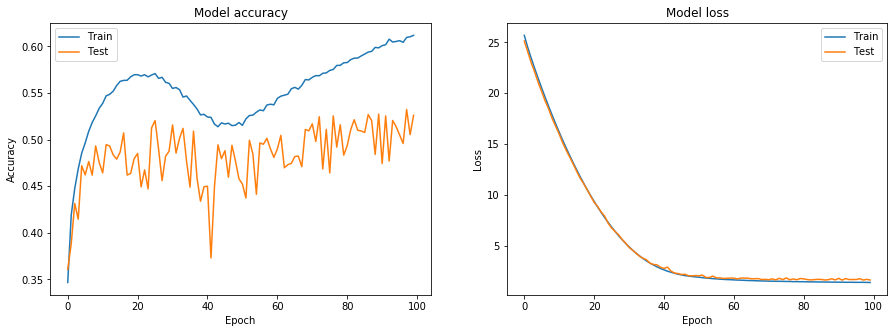

In [34]:
_,acc = model_1_reg.evaluate(test_x_scaled, test_y, verbose=0)
plot_history(history_1_reg, acc)

###Oscillating Accuracies

The following shows an example of how accuracies oscillates when the L1 and L2 values are larger. The model is seems to be generalized as the training and validation accuracies are close to each other. 


In [0]:
l1_l2 = regularizers.l1_l2(l1=0.001,l2=0.001)

In [36]:
model_1_reg_osc = tf.keras.models.Sequential(name='FNN-1-Reg', layers=[
    Dense(3072, activation='relu',kernel_initializer=init_w,bias_initializer=init_w,input_shape= (3072,), kernel_regularizer=l1_l2, bias_regularizer=l1_l2), 
    Dense(2054, activation='relu',kernel_initializer=init_w,bias_initializer=init_w, kernel_regularizer=l1_l2, bias_regularizer=l1_l2),   
    Dense(10, activation = 'softmax')
])

model_1_reg_osc.summary()
model_1_reg_osc.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_1_reg_osc = model_1_reg_osc.fit(train_x_scaled, train_y,validation_split=0.2,shuffle=True, batch_size=batch_size,epochs=epoch ,verbose=1)

Model: "FNN-1-Reg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_4 (Dense)              (None, 2054)              6311942   
_________________________________________________________________
dense_5 (Dense)              (None, 10)                20550     
Total params: 15,772,748
Trainable params: 15,772,748
Non-trainable params: 0
_________________________________________________________________
Train on 40000 samples, validate on 10000 samples
Epoch 1/60
40000/40000 [==============================] - 8s 202us/sample - loss: 279.6119 - accuracy: 0.3492 - val_loss: 204.7890 - val_accuracy: 0.3563
Epoch 2/60
40000/40000 [==============================] - 7s 185us/sample - loss: 145.6121 - accuracy: 0.3883 - val_loss: 93.5618 - val_accuracy: 0.3346
Epoch 3/60
40000/4

Training accuracy: 32.500
Validation accuracy: 29.970
Testing accuracy: 30.320



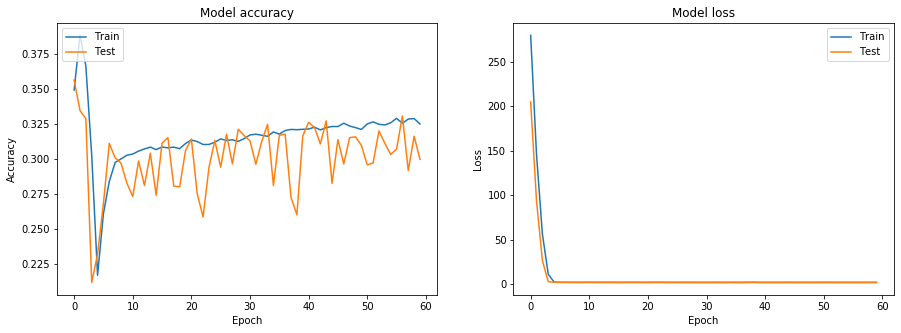

In [37]:
_,acc = model_1_reg_osc.evaluate(test_x_scaled, test_y, verbose=0)
plot_history(history_1_reg_osc, acc)

##Dropout Regularization

As deep learning networks have large number of layers and parameters, it becomes clear that applying L1 or L2 regularization might lead to slower training time due to requiring more calculations to be done. One way to regularize a deep neural network would be to use dropout.

Dropout in neural networks meant that certain nodes within a layer would be "deactivated" based on the dropout rate for that layer. This would prevent the next layer of the network to correct problems of the previous layer [4]. Thus this would make the network more robust and learn more "generally", therefore acheiving the objective of reducing overfitting.

### Model 3 (Dropout)

Defining the model and using 30% dropout rate for most of the layers.

These rates were determined through trials and testing. When assigned with higher dropout rates, we noticed that there is a decrease in overall accuracy of the model. Perhaps, in this situation, we would require more data to train the model to improve the accuracy.


In [38]:
model_3_reg = tf.keras.models.Sequential([
    Dense(2054, activation='relu', kernel_initializer=init_w,  input_shape= (3072,)),
    Dropout(rate=0.3),
    Dense(1376, activation='relu', kernel_initializer=init_w),
    Dropout(rate=0.3),
    Dense(32, activation='relu', kernel_initializer=init_w),
    Dense(1376, activation='relu', kernel_initializer=init_w),
    Dropout(rate=0.3),
    Dense(2054, activation='relu', kernel_initializer=init_w),
    Dropout(rate=0.3),
    Dense(10, activation = 'softmax')
])

model_3_reg.summary()

model_3_reg.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cp_3_reg = '/content/SavedModel/best_3_model.h5'

mc = get_mc(cp_3_reg)

history_3_reg = model_3_reg.fit(train_x_scaled, train_y,epochs=100,validation_split=0.2,shuffle=True, batch_size=batch_size, callbacks=[mc])
model_3_reg_best = models.load_model(cp_3_reg)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2054)              6311942   
_________________________________________________________________
dropout (Dropout)            (None, 2054)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1376)              2827680   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1376)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                44064     
_________________________________________________________________
dense_9 (Dense)              (None, 1376)              45408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1376)              0

###Evaluation

In the following charts, you could see that the training accuracy does not deviate much from validation accuracy during the early epochs compared to unregularized model.

At later epochs, the overfitting problem came back. A possible solution to this issue would be to implement early stopping.

Training accuracy: 74.655
Validation accuracy: 54.130
Testing accuracy: 54.630



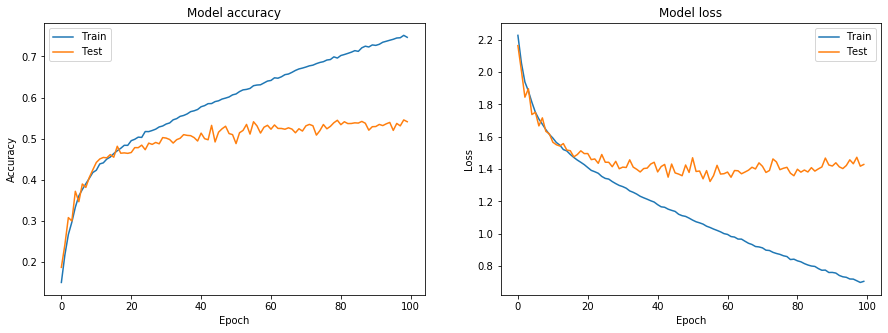

In [39]:
_,acc = model_3_reg_best.evaluate(test_x_scaled, test_y, verbose=0)
plot_history(history_3_reg, acc)

## Early Stopping

Early stopping is a way to stop the neural network from overfitting. In this particular scenario, we will borrow the previous model with dropouts and perform an early stop.

### Model 3 (Early Stopping)

The following defines the model and indicate the early stop parameters.

In this case, we set the paramters to monitor validation accuracy, and stop the training if the validation accuracy has not improved over 3 epochs (patience).

The patience is determined through trials. We first set to stop after 1 epoch of no improvement. We realise that the accuracy is quite low, therefore setting it to 5 epochs to get higher validation accuracy.


In [40]:
earlystop = callbacks.EarlyStopping(patience=3, monitor='val_accuracy', min_delta=0.0001)

model_3_es = tf.keras.models.Sequential([
    Dense(2054, activation='relu', kernel_initializer=init_w,  input_shape= (3072,)),
    Dropout(rate=0.3),
    Dense(1376, activation='relu', kernel_initializer=init_w),
    Dropout(rate=0.3),
    Dense(32, activation='relu', kernel_initializer=init_w),
    Dense(1376, activation='relu', kernel_initializer=init_w),
    Dropout(rate=0.3),
    Dense(2054, activation='relu', kernel_initializer=init_w),
    Dropout(rate=0.3),
    Dense(10, activation = 'softmax')
])

model_3_es.summary()

model_3_es.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_3_es = model_3_es.fit(train_x_scaled, train_y,epochs=epoch,validation_split=0.2,shuffle=True, batch_size=batch_size, callbacks=[earlystop])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 2054)              6311942   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2054)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1376)              2827680   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1376)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                44064     
_________________________________________________________________
dense_15 (Dense)             (None, 1376)              45408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1376)             

### Evaluation

In the following chart, we could see that not all 60 epochs are completed. The training stops after 23 epochs of no improvement. 

Training accuracy: 48.772
Validation accuracy: 46.460
Testing accuracy: 47.550



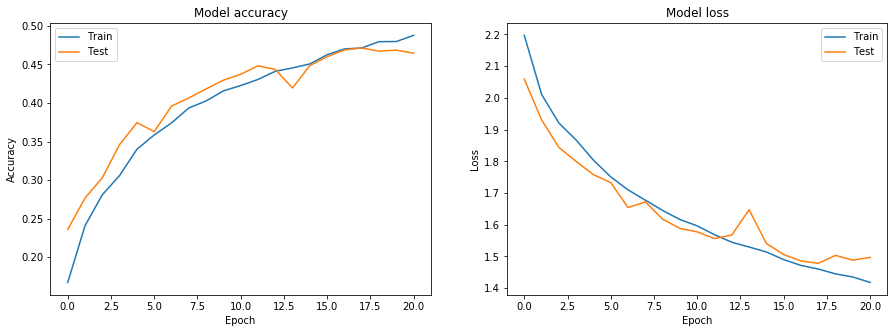

In [41]:
_,acc = model_3_es.evaluate(test_x_scaled, test_y, verbose=0)
plot_history(history_3_es, acc)

# References

[1] [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.

[2] [Hidden Layers](https://www.heatonresearch.com/2017/06/01/hidden-layers.html), Jeff Heaton, 2017.

[3] [Hyper-parameters in Action! Part II — Weight Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404), Daniel Godoy, 2018.

[4] [A Gentle Introduction to Dropout for Regularizing Deep Neural Networks](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/), Jason Brownlee, 2018.